In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from mrmr import mrmr_classif

/home/x1b3d3ad/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# https://www.kaggle.com/datasets/vishalpnaik/mushroom-classification-edible-or-poisonous
df = pd.read_csv('data/mushroom.csv')
df.dropna()
df = df.sample(frac=.1).reset_index(drop=True) # work with .1 of the data from training

""" standardize the quantitative variables """
quantitative = ['cap-diameter', 'stem-height', 'stem-width']
df[quantitative] = StandardScaler().fit_transform(df[quantitative])

""" define categorical variables and convert them to one-hot encoding"""
categorical = list(set(df.columns.tolist()) - set(quantitative) - set(['class']))
for cat in categorical: # fill in NAN values with the mode
    df[cat].fillna('misssing', inplace=True)
df = pd.get_dummies(df, columns=categorical)
print(df.columns)

""" Perform mrmr feature selection. 0 = edible, 1 = poisonous"""
target = 'class'
df[target] = df[target].apply(lambda x: 0 if x == 'e' else 1)
print(df[target].value_counts())

features = df.columns.tolist()
features.remove(target)

# selectedFeatures = mrmr_classif(X=df[features], y=df[target], K=len(features))
selectedFeatures = ['stem-color_w', 'stem-root_r', 'season_w', 'ring-type_z', 'stem-width', 'cap-surface_k', 'cap-color_r', 'veil-color_y', 'cap-shape_b', 'stem-surface_g']
selectedFeatures = selectedFeatures[:10]
print(f'Most valuable features: {selectedFeatures}')

Index(['class', 'cap-diameter', 'stem-height', 'stem-width', 'cap-shape_b',
       'cap-shape_c', 'cap-shape_f', 'cap-shape_o', 'cap-shape_p',
       'cap-shape_s',
       ...
       'ring-type_r', 'ring-type_z', 'habitat_d', 'habitat_g', 'habitat_h',
       'habitat_l', 'habitat_m', 'habitat_p', 'habitat_u', 'habitat_w'],
      dtype='object', length=129)
class
1    3416
0    2691
Name: count, dtype: int64
Most valuable features: ['stem-color_w', 'stem-root_r', 'season_w', 'ring-type_z', 'stem-width', 'cap-surface_k', 'cap-color_r', 'veil-color_y', 'cap-shape_b', 'stem-surface_g']


In [3]:
# Perform PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df[selectedFeatures])
print(principalComponents)

[[ 2.15189882 -0.49734519]
 [-0.7657197  -0.66584201]
 [-0.66618341  0.33826821]
 ...
 [-0.59759779 -0.69766279]
 [-1.00920153 -0.65385584]
 [-0.65330662  0.33890665]]


Average F1 score: 0.5660786768922104


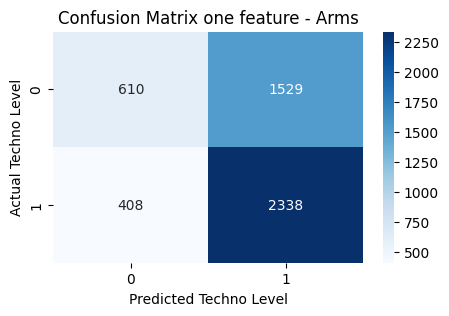

In [4]:
""" Perform a SVM classification on the data"""
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer, confusion_matrix

X = principalComponents
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = SVC(kernel='poly', degree=3, C=1, gamma='auto')

scorer = make_scorer(f1_score, average='weighted')
average_f1 = cross_val_score(model, X_train, y_train, cv=2, scoring=scorer)
print(f'Average F1 score: {np.mean(average_f1)}')

y_pred = cross_val_predict(model, X_train, y_train, cv=2)
conf_matrix = confusion_matrix(y_train,  y_pred) 

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Techno Level')
plt.ylabel('Actual Techno Level')
plt.title('Confusion Matrix one feature - Arms')
plt.show()

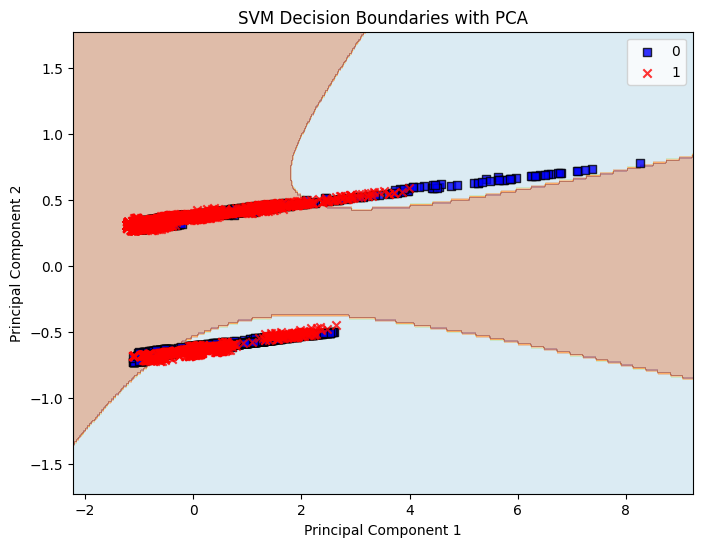

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Assuming principalComponents contains the transformed data after PCA
X = principalComponents
y = df[target]

model = SVC(kernel='poly', degree=3, C=1, random_state=0, gamma='auto')
model.fit(X, y)

# Define plotting functions for decision boundaries
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Setup marker generator and color map
    markers = ('s', 'x')
    colors = ('blue', 'red')
    cmap = plt.cm.Paired

    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=[colors[idx]], marker=markers[idx], label=cl, edgecolor='black')

# Plot decision regions and data points
plt.figure(figsize=(8, 6))
plot_decision_regions(X, y, classifier=model)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Boundaries with PCA')

# Add legend
plt.legend(loc='upper right')
plt.show()
